In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 设置随机种子以确保结果可复现
np.random.seed(42)

# 定义参数
n_samples = 10000  # 每个数据集的样本数
n_features = 200   # 特征维度
train_size = 7000  # 训练集大小
test_size = 3000   # 测试集大小

# 创建第一个数据集 - 标签为0
# 特征服从均值为-1，方差为10的正态分布
X_class0 = np.random.normal(loc=-1, scale=10, size=(n_samples, n_features))
y_class0 = np.zeros(n_samples)  # 标签为0

# 创建第二个数据集 - 标签为1
# 特征服从均值为1，方差为10的正态分布
X_class1 = np.random.normal(loc=1, scale=10, size=(n_samples, n_features))
y_class1 = np.ones(n_samples)   # 标签为1

# 合并两个数据集
X = np.vstack((X_class0, X_class1))
y = np.hstack((y_class0, y_class1))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, 
    test_size=test_size, 
    random_state=42,
    stratify=y  # 保持类别比例
)

print(f"数据集生成完成：")
print(f"训练集形状: X={X_train.shape}, y={y_train.shape}")
print(f"测试集形状: X={X_test.shape}, y={y_test.shape}")
print(f"训练集中各类别样本数: {np.bincount(y_train.astype(int))}")
print(f"测试集中各类别样本数: {np.bincount(y_test.astype(int))}")


数据集生成完成：
训练集形状: X=(7000, 200), y=(7000,)
测试集形状: X=(3000, 200), y=(3000,)
训练集中各类别样本数: [3500 3500]
测试集中各类别样本数: [1500 1500]


In [26]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

class FeedForwardNNBinary:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001, l2_lambda=0.01, dropout_rate=0.3):
        """
        初始化二分类前馈神经网络 (完全对齐 PyTorch: L2 + Dropout)
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = learning_rate
        self.l2_lambda = l2_lambda
        self.dropout_rate = dropout_rate
        
        # 初始化权重 (He Initialization)
        np.random.seed(42) 
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))
        
        self.history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'epochs': []}
        self.mask = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return np.where(x > 0, 1, 0)

    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-8
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def forward(self, X, training=True):
        """前向传播 (含 Inverted Dropout)"""
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # Dropout
        if training and self.dropout_rate > 0:
            self.mask = (np.random.rand(*self.a1.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
            self.a1 *= self.mask
        else:
            self.mask = None
        
        # Layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y_true):
        """反向传播 (含 Weight Decay)"""
        m = X.shape[0]
        if y_true.ndim == 1: y_true = y_true.reshape(-1, 1)
        
        # Layer 2 Error
        delta2 = (self.a2 - y_true) / m
        
        # Layer 1 Error (Need to apply mask backward)
        delta1_temp = np.dot(delta2, self.W2.T)
        if self.mask is not None:
            delta1_temp *= self.mask
        delta1 = delta1_temp * self.relu_deriv(self.z1)
        
        # Gradients (With direct Weight Decay, no division by m)
        dW2 = np.dot(self.a1.T, delta2) + self.l2_lambda * self.W2
        db2 = np.sum(delta2, axis=0, keepdims=True)
        
        dW1 = np.dot(X.T, delta1) + self.l2_lambda * self.W1
        db1 = np.sum(delta1, axis=0, keepdims=True)
        
        # Update
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X, threshold=0.5):
        probabilities = self.forward(X, training=False)
        return (probabilities > threshold).astype(int)

    def predict_proba(self, X):
        return self.forward(X, training=False)

    def compute_metrics(self, X, y_true):
        y_pred = self.predict(X)
        y_proba = self.predict_proba(X)
        loss = self.binary_cross_entropy(y_true.reshape(-1, 1), y_proba)
        accuracy = accuracy_score(y_true, y_pred)
        return loss, accuracy

    # === 补回的方法 ===
    def evaluate(self, X, y, set_name="数据集"):
        """全面评估模型性能"""
        y_pred = self.predict(X)
        y_proba = self.predict_proba(X)
        
        # 计算指标
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        loss = self.binary_cross_entropy(y.reshape(-1, 1), y_proba)
        
        print(f"\n{set_name}评估结果:")
        print(f"损失: {loss:.4f}")
        print(f"准确率: {accuracy:.4f}")
        print(f"精确率: {precision:.4f}")
        print(f"召回率: {recall:.4f}")
        print(f"F1分数: {f1:.4f}")
        
        # 绘制混淆矩阵
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['pred_0', 'pred_1'], 
                    yticklabels=['True_0', 'True_1'])
        plt.title(f'{set_name} Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        return {'loss': loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    # =================

    def train(self, X_train, y_train, X_test=None, y_test=None, 
              epochs=500, batch_size=64, verbose=True, early_stopping=True, patience=20):
        m = X_train.shape[0]
        best_test_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward(X_batch, training=True)
                self.backward(X_batch, y_batch)
            
            train_loss, train_acc = self.compute_metrics(X_train, y_train)
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['epochs'].append(epoch + 1)
            
            if X_test is not None:
                test_loss, test_acc = self.compute_metrics(X_test, y_test)
                self.history['test_loss'].append(test_loss)
                self.history['test_acc'].append(test_acc)
                
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")
                
                if early_stopping:
                    if test_loss < best_test_loss:
                        best_test_loss = test_loss
                        patience_counter = 0
                        best_weights = {
                            'W1': self.W1.copy(), 'b1': self.b1.copy(),
                            'W2': self.W2.copy(), 'b2': self.b2.copy()
                        }
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"早停触发于 Epoch {epoch+1}")
                            if best_weights:
                                self.W1, self.b1 = best_weights['W1'], best_weights['b1']
                                self.W2, self.b2 = best_weights['W2'], best_weights['b2']
                            break

# 创建并训练模型
print("创建神经网络模型...")
model = FeedForwardNNBinary(
    input_dim=200,      # 特征维度
    hidden_dim=128,     # 隐藏层神经元数量
    output_dim=1,       # 输出维度（二分类）
    learning_rate=0.001,
    l2_lambda=0.001,
    dropout_rate=0.3
)

print("开始训练...")
model.train(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=500,
    batch_size=64,
    verbose=True,
    early_stopping=True,
    patience=20
)

创建神经网络模型...
开始训练...
Epoch 10/500 | Train Loss: 0.2871 Acc: 0.8794 | Test Loss: 0.3009 Acc: 0.8770
Epoch 20/500 | Train Loss: 0.2764 Acc: 0.8857 | Test Loss: 0.2912 Acc: 0.8793
Epoch 30/500 | Train Loss: 0.2525 Acc: 0.8977 | Test Loss: 0.2681 Acc: 0.8853
Epoch 40/500 | Train Loss: 0.2390 Acc: 0.8990 | Test Loss: 0.2574 Acc: 0.8933
Epoch 50/500 | Train Loss: 0.2318 Acc: 0.9077 | Test Loss: 0.2547 Acc: 0.8967
Epoch 60/500 | Train Loss: 0.2156 Acc: 0.9129 | Test Loss: 0.2405 Acc: 0.9003
Epoch 70/500 | Train Loss: 0.2107 Acc: 0.9159 | Test Loss: 0.2388 Acc: 0.9023
Epoch 80/500 | Train Loss: 0.2042 Acc: 0.9171 | Test Loss: 0.2284 Acc: 0.9083
Epoch 90/500 | Train Loss: 0.1978 Acc: 0.9211 | Test Loss: 0.2250 Acc: 0.9090
Epoch 100/500 | Train Loss: 0.1935 Acc: 0.9221 | Test Loss: 0.2214 Acc: 0.9100
Epoch 110/500 | Train Loss: 0.1971 Acc: 0.9194 | Test Loss: 0.2311 Acc: 0.9020
Epoch 120/500 | Train Loss: 0.2147 Acc: 0.9094 | Test Loss: 0.2524 Acc: 0.8967
Epoch 130/500 | Train Loss: 0.1836 Acc: 0

In [27]:
def plot_training_history(history, figsize=(12, 5)):
    """
    绘制训练历史的独立函数
    
    参数:
    history: 包含训练历史的字典，应包含以下键:
        - 'epochs': 训练轮次列表
        - 'train_loss': 训练损失列表
        - 'train_acc': 训练准确率列表 (可选)
        - 'test_loss': 测试损失列表 (可选)
        - 'test_acc': 测试准确率列表 (可选)
    figsize: 图形大小
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 确定是否有准确率数据
    has_accuracy = 'train_acc' in history and history['train_acc'] is not None
    
    # 如果没有准确率数据，只绘制损失图
    if not has_accuracy:
        axes = [axes] if not hasattr(axes, '__len__') else axes
        ax = axes[0] if len(axes) > 0 else plt.gca()
        
        # 损失曲线
        ax.plot(history['epochs'], history['train_loss'], label='Train Loss', linewidth=2)
        if 'test_loss' in history and any(loss is not None for loss in history['test_loss']):
            ax.plot(history['epochs'], history['test_loss'], label='Test Loss', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Testing Losses')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 如果有第二个子图位置，移除它
        if len(axes) > 1:
            axes[1].remove()
    
    else:
        # 损失曲线
        axes[0].plot(history['epochs'], history['train_loss'], label='Train Loss', linewidth=2)
        if 'test_loss' in history and any(loss is not None for loss in history['test_loss']):
            axes[0].plot(history['epochs'], history['test_loss'], label='Test Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Testing Losses')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # 准确率曲线
        axes[1].plot(history['epochs'], history['train_acc'], label='Train Acc', linewidth=2)
        if 'test_acc' in history and any(acc is not None for acc in history['test_acc']):
            axes[1].plot(history['epochs'], history['test_acc'], label='Test Acc', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training and Testing Losses')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



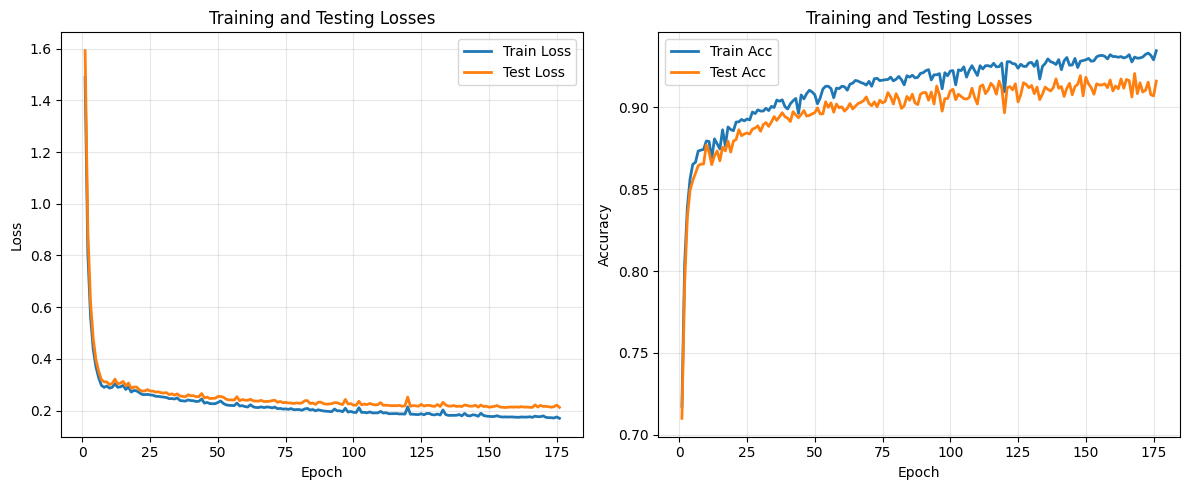


Train set评估结果:
损失: 0.1759
准确率: 0.9317
精确率: 0.9322
召回率: 0.9311
F1分数: 0.9317


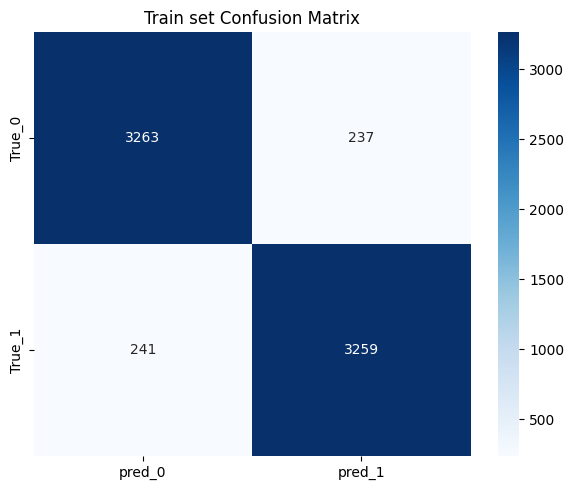


Test set评估结果:
损失: 0.2121
准确率: 0.9137
精确率: 0.9001
召回率: 0.9307
F1分数: 0.9151


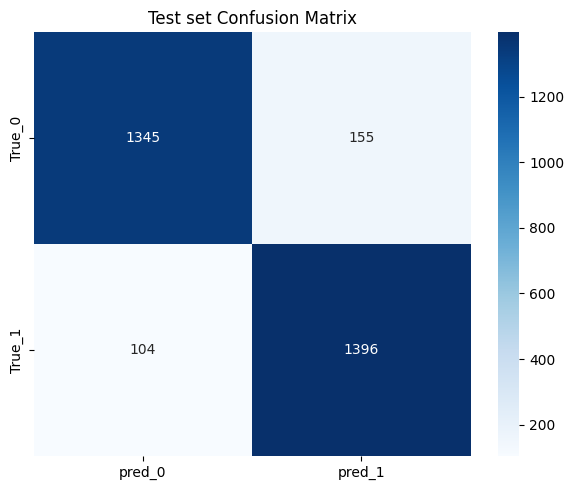

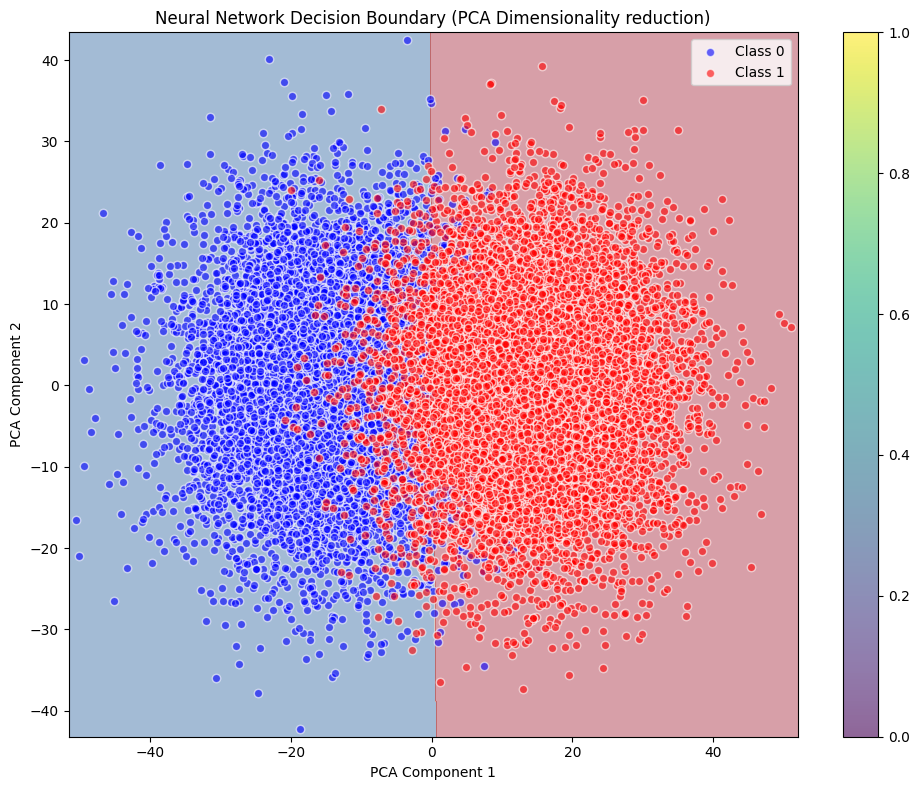

In [28]:
# 绘制训练历史
plot_training_history(history=model.history)

# 评估模型性能
train_metrics = model.evaluate(X_train, y_train, "Train set")
test_metrics = model.evaluate(X_test, y_test, "Test set")

# 可视化决策边界（使用PCA降维）
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 创建网格数据用于绘制决策边界
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 将网格点转换回原始空间进行预测
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_points_original = pca.inverse_transform(mesh_points)
Z = model.predict(mesh_points_original)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu_r')
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], c='blue', label='Class 0', alpha=0.6, edgecolors='w')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], c='red', label='Class 1', alpha=0.6, edgecolors='w')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Neural Network Decision Boundary (PCA Dimensionality reduction)')
plt.legend()
plt.colorbar()
plt.tight_layout()
plt.show()